<a href="https://colab.research.google.com/github/asgutierrt/Introduction-to-IA/blob/main/convolutional_networks/lnet5_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import os
from PIL import Image
from IPython.display import clear_output
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

!git clone https://github.com/asgutierrt/Introduction-to-IA.git

# assign directory
data_path = '/content/Introduction-to-IA/convolutional_networks/mnist_data/'

fatal: destination path 'Introduction-to-IA' already exists and is not an empty directory.


# to 'label' hand written digits

In [5]:
# labeled data is already available at the repository data folder
manual_label=False

if manual_label:
  # iterate over files
  img_dir_path=data_path+"numbers-pngs"
  imgs_names=os.listdir(img_dir_path)
  rows,cols=(28,28)
  images_df = pd.DataFrame(index=range(len(imgs_names)),columns=list(range(rows * cols))+['label'],dtype=float)
  for i, im_filename in enumerate(imgs_names):
      with Image.open(img_dir_path+'/'+im_filename) as image:
          new_image = image.resize((rows,cols))
          plt.imshow(new_image); plt.show()
          images_df.iloc[i,:-1]=np.array(new_image).flatten() / 255
          images_df.loc[i,'label']=input()
          clear_output()
  images_df.to_csv('numbers.csv')

# Import MNIST data for training

In [28]:
import numpy as np
import pandas as pd
from array import array
import struct
from os.path  import join

from sklearn.model_selection import train_test_split
import random
import matplotlib.pyplot as plt

import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

from sklearn.metrics import confusion_matrix
import seaborn as sns

# training dataset found at https://www.kaggle.com/datasets/hojjatk/mnist-dataset

# MNIST Data Loader Class
class MnistDataloader(object):
    def __init__(self, training_images_filepath,training_labels_filepath,
                 test_images_filepath, test_labels_filepath):
        self.training_images_filepath = training_images_filepath
        self.training_labels_filepath = training_labels_filepath
        self.test_images_filepath = test_images_filepath
        self.test_labels_filepath = test_labels_filepath

    def read_images_labels(self, images_filepath, labels_filepath):
        labels = []
        with open(labels_filepath, 'rb') as file:
            magic, size = struct.unpack(">II", file.read(8))
            if magic != 2049: raise ValueError('Magic number mismatch, expected 2049, got {}'.format(magic))
            labels = array("B", file.read())

        with open(images_filepath, 'rb') as file:
            magic, size, rows, cols = struct.unpack(">IIII", file.read(16))
            if magic != 2051: raise ValueError('Magic number mismatch, expected 2051, got {}'.format(magic))
            image_data = array("B", file.read())

        images = pd.DataFrame(index=range(size),columns=range(rows * cols),dtype=float)
        for i in range(size):
            # The network will converge faster with normalized values
            img =np.array(image_data[i * rows * cols:(i + 1) * rows * cols]) / 255
            images.iloc[i,:]=(img-0.5)*2

        return images, labels

    def load_data(self):
        x_train, y_train = self.read_images_labels(self.training_images_filepath, self.training_labels_filepath)
        x_test, y_test = self.read_images_labels(self.test_images_filepath, self.test_labels_filepath)
        return (x_train, pd.Series(y_train)),(x_test, pd.Series(y_test))

# iterate over files
training_images_filepath = join(data_path, 'train-images.idx3-ubyte')
training_labels_filepath = join(data_path, 'train-labels.idx1-ubyte')
test_images_filepath = join(data_path, 't10k-images.idx3-ubyte')
test_labels_filepath = join(data_path, 't10k-labels.idx1-ubyte')

# Load MINST dataset
mnist_dataloader = MnistDataloader(training_images_filepath, training_labels_filepath, test_images_filepath, test_labels_filepath)
(x_train, y_train), (x_valid, y_valid) = mnist_dataloader.load_data()

In [29]:
# Split train and test sets
train_x, test_x, train_y, test_y = train_test_split(x_train,y_train,test_size=0.2)

print("Training set size: {}".format(train_x.shape))
print("Validation set size: {}".format(test_x.shape))
print("Test set size: {}".format(x_valid.shape))

Training set size: (48000, 784)
Validation set size: (12000, 784)
Test set size: (10000, 784)


In [32]:
# read class images
own_images=pd.read_csv(data_path+'hand_written_numbers.csv',index_col=0)
own_images_digits=own_images.drop(own_images[own_images['label']=='X'].index)
img_x=own_images.drop(own_images[own_images['label']!='X'].index)

(x_valid, y_valid)=own_images_digits.iloc[:,:-1].applymap(lambda x: (1-float(x)-0.5)*2), own_images_digits.iloc[:,-1]
(img_x, _)=img_x.iloc[:,:-1].applymap(lambda x: (1-float(x)-0.5)*2), img_x.iloc[:,-1]

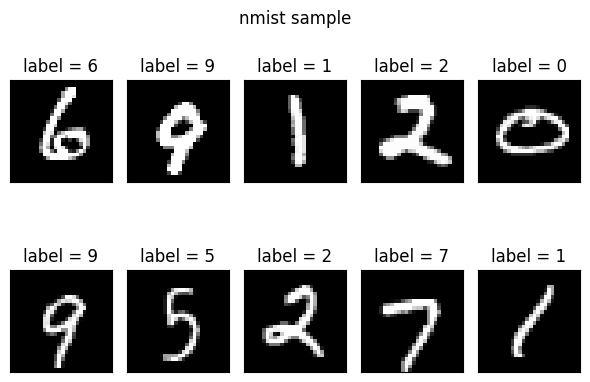

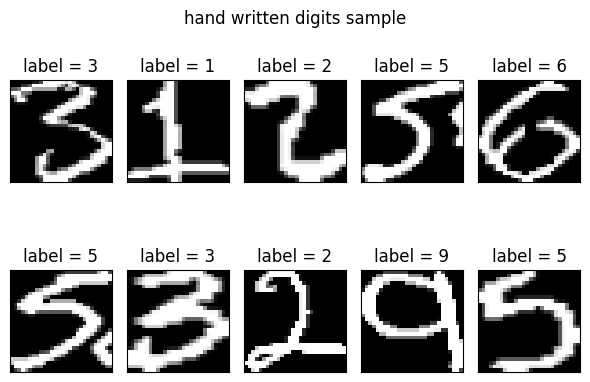

In [52]:
# Helper function to show a list of images with their relating titles
def show_images(images, title_texts, figsize=(6,5), title=''):
    cols = 5; rows = int(np.ceil(len(images)/cols))
    fig=plt.figure(figsize=figsize)
    index = 1
    for image, title_text in zip(images, title_texts):
        ax=plt.subplot(rows, cols, index)
        plt.imshow(image, cmap=plt.cm.gray)
        if (title_text != ''):
            ax.set_title(title_text);
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
        index += 1
    fig.suptitle(title, y=0.9)
    plt.tight_layout()


# Show some random training and test images
images_2_show = []; titles_2_show = []
for i in range(0, 10):
    r = random.randint(1, 60000)
    images_2_show.append(x_train.iloc[r].values.reshape(28, 28))
    titles_2_show.append('label = ' + str(y_train.iloc[r]))

show_images(images_2_show, titles_2_show, title='nmist sample')
plt.savefig('mnist_sample.png'); plt.show()

images_2_show = []; titles_2_show = []
for i in range(0, 10):
    r = random.randint(1, len(x_valid))
    images_2_show.append(x_valid.iloc[r].values.reshape(28, 28))
    titles_2_show.append('label = ' + str(y_valid.iloc[r]))

show_images(images_2_show, titles_2_show, title='hand written digits sample')
plt.savefig('hand_written_sample.png'); plt.show()

# Train CNN model with LNET5 architecture

In [34]:
# LeNet-5 Model architecture
def model(train_x, train_y, valid_x, valid_y, test_x, img_x, learning_rate=0.0001, batch_size=128, num_epochs=1000):

    # Create placeholder for model input and label.
    # Input shape is (minbatch_size, 28, 28)
    X = tf.placeholder(tf.float32, [None, 28, 28], name="X")
    Y = tf.placeholder(tf.int64, [None, ], name="Y")

    def CNN(X):
        # Here we defind the CNN architecture (LeNet-5)

        # Reshape input to 4-D vector
        input_layer = tf.reshape(X, [-1, 28, 28, 1]) # -1 adds minibatch support.

        # Padding the input to make it 32x32. Specification of LeNET
        padded_input = tf.pad(input_layer, [[0, 0], [2, 2], [2, 2], [0, 0]], "CONSTANT")

        # Convolutional Layer #1
        # Has a default stride of 1
        # Output: 28 * 28 * 6
        conv1 = tf.layers.conv2d(
          inputs=padded_input,
          filters=6, # Number of filters.
          kernel_size=5, # Size of each filter is 5x5.
          padding="valid", # No padding is applied to the input.
          activation=tf.nn.relu)

        # Pooling Layer #1
        # Sampling half the output of previous layer
        # Output: 14 * 14 * 6
        pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], strides=2)

        # Convolutional Layer #2
        # Output: 10 * 10 * 16
        conv2 = tf.layers.conv2d(
          inputs=pool1,
          filters=16, # Number of filters
          kernel_size=5, # Size of each filter is 5x5
          padding="valid", # No padding
          activation=tf.nn.relu)

        # Pooling Layer #2
        # Output: 5 * 5 * 16
        pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2], strides=2)

        # Reshaping output into a single dimention array for input to fully connected layer
        pool2_flat = tf.reshape(pool2, [-1, 5 * 5 * 16])

        # Fully connected layer #1: Has 120 neurons
        dense1 = tf.layers.dense(inputs=pool2_flat, units=120, activation=tf.nn.relu)

        # Fully connected layer #2: Has 84 neurons
        dense2 = tf.layers.dense(inputs=dense1, units=84, activation=tf.nn.relu)

        # Output layer, 10 neurons for each digit
        logits = tf.layers.dense(inputs=dense2, units=10)

        return logits

    # Pass the input thorough our CNN
    logits = CNN(X)
    softmax = tf.nn.softmax(logits)

    # Convert our labels into one-hot-vectors
    labels = tf.one_hot(indices=tf.cast(Y, tf.int32), depth=10)

    # Compute the cross-entropy loss
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits,
                                                                     labels=labels))
    # Use adam optimizer to reduce cost
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
    train_op = optimizer.minimize(cost)

    # For testing and prediction
    predictions = tf.argmax(softmax, axis=1)
    correct_prediction = tf.equal(predictions, Y)
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

    # Initialize all the variables
    init = tf.global_variables_initializer()


    # Running the model
    with tf.Session() as sess:

        sess.run(init)

        for epoch in range(num_epochs):
            num_samples = train_x.shape[0]
            num_batches = (num_samples // batch_size) + 1
            epoch_cost = 0.
            i = 0
            while i < num_samples:
                batch_x = train_x.iloc[i:i+batch_size,:].values
                batch_x = batch_x.reshape(batch_x.shape[0], 28, 28)

                batch_y = train_y.iloc[i:i+batch_size].values

                i += batch_size

                # Train on batch and get back cost
                _, c = sess.run([train_op, cost], feed_dict={X:batch_x, Y:batch_y})
                epoch_cost += (c/num_batches)

            # Get accuracy for validation
            valid_accuracy = accuracy.eval(
                feed_dict={X:valid_x.values.reshape(valid_x.shape[0], 28, 28),
                           Y:valid_y.values})

            print ("Epoch {}: Cost: {}".format(epoch+1, epoch_cost))
            print("Validation accuracy: {}".format(valid_accuracy))

        return predictions.eval(feed_dict={X:test_x.values.reshape(test_x.shape[0], 28, 28)}), predictions.eval(feed_dict={X:img_x.values.reshape(img_x.shape[0], 28, 28)})

In [35]:
# Run for more epochs for better accuracy
y_valid_pred, Y_x_pred = model(train_x, train_y, test_x, test_y, x_valid, img_x, learning_rate=0.0001, batch_size=64, num_epochs=5)

<ipython-input-34-1fc9e98cab49>:21: UserWarning: `tf.layers.conv2d` is deprecated and will be removed in a future version. Please Use `tf.keras.layers.Conv2D` instead.
  conv1 = tf.layers.conv2d(
<ipython-input-34-1fc9e98cab49>:31: UserWarning: `tf.layers.max_pooling2d` is deprecated and will be removed in a future version. Please use `tf.keras.layers.MaxPooling2D` instead.
  pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], strides=2)
<ipython-input-34-1fc9e98cab49>:35: UserWarning: `tf.layers.conv2d` is deprecated and will be removed in a future version. Please Use `tf.keras.layers.Conv2D` instead.
  conv2 = tf.layers.conv2d(
<ipython-input-34-1fc9e98cab49>:44: UserWarning: `tf.layers.max_pooling2d` is deprecated and will be removed in a future version. Please use `tf.keras.layers.MaxPooling2D` instead.
  pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2], strides=2)
<ipython-input-34-1fc9e98cab49>:50: UserWarning: `tf.layers.dense` is deprecated and will be

Epoch 1: Cost: 0.8255999478574757
Validation accuracy: 0.9153333306312561
Epoch 2: Cost: 0.23095560200839815
Validation accuracy: 0.9483333230018616
Epoch 3: Cost: 0.15328942149996588
Validation accuracy: 0.9606666564941406
Epoch 4: Cost: 0.1157944577233928
Validation accuracy: 0.9672499895095825
Epoch 5: Cost: 0.09454233674196082
Validation accuracy: 0.9714166522026062


# visualize results on 'salon' data

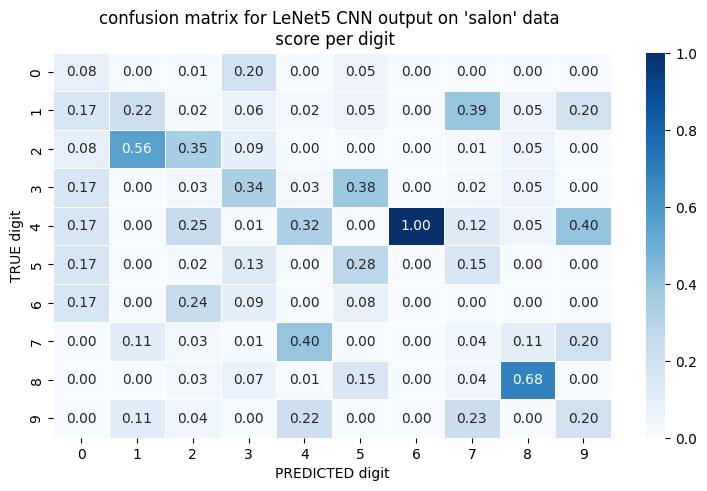

In [36]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# evaluar error final del modelo
C1=confusion_matrix(np.array(y_valid.astype(int)), np.array(y_valid_pred))

plt.figure(figsize=(9,5))
plt.title("confusion matrix for LeNet5 CNN output on 'salon' data \n score per digit")
sns.heatmap(C1/C1.sum(axis=0), annot = True, fmt=".2f", linewidths=.5, cmap="Blues")
plt.xlabel('PREDICTED digit'); plt.ylabel('TRUE digit');
plt.savefig('confusion_matrix.png'); plt.show()

In [69]:
per_digit_scr=(C1/C1.sum(axis=0)).diagonal()
pd.DataFrame(per_digit_scr,index=list(range(10)),columns=['accuracy']).T

,0,1,2,3,4,5,6,7,8,9
accuracy,0.083333,0.222222,0.348624,0.335277,0.322581,0.282051,0.0,0.035714,0.684211,0.2


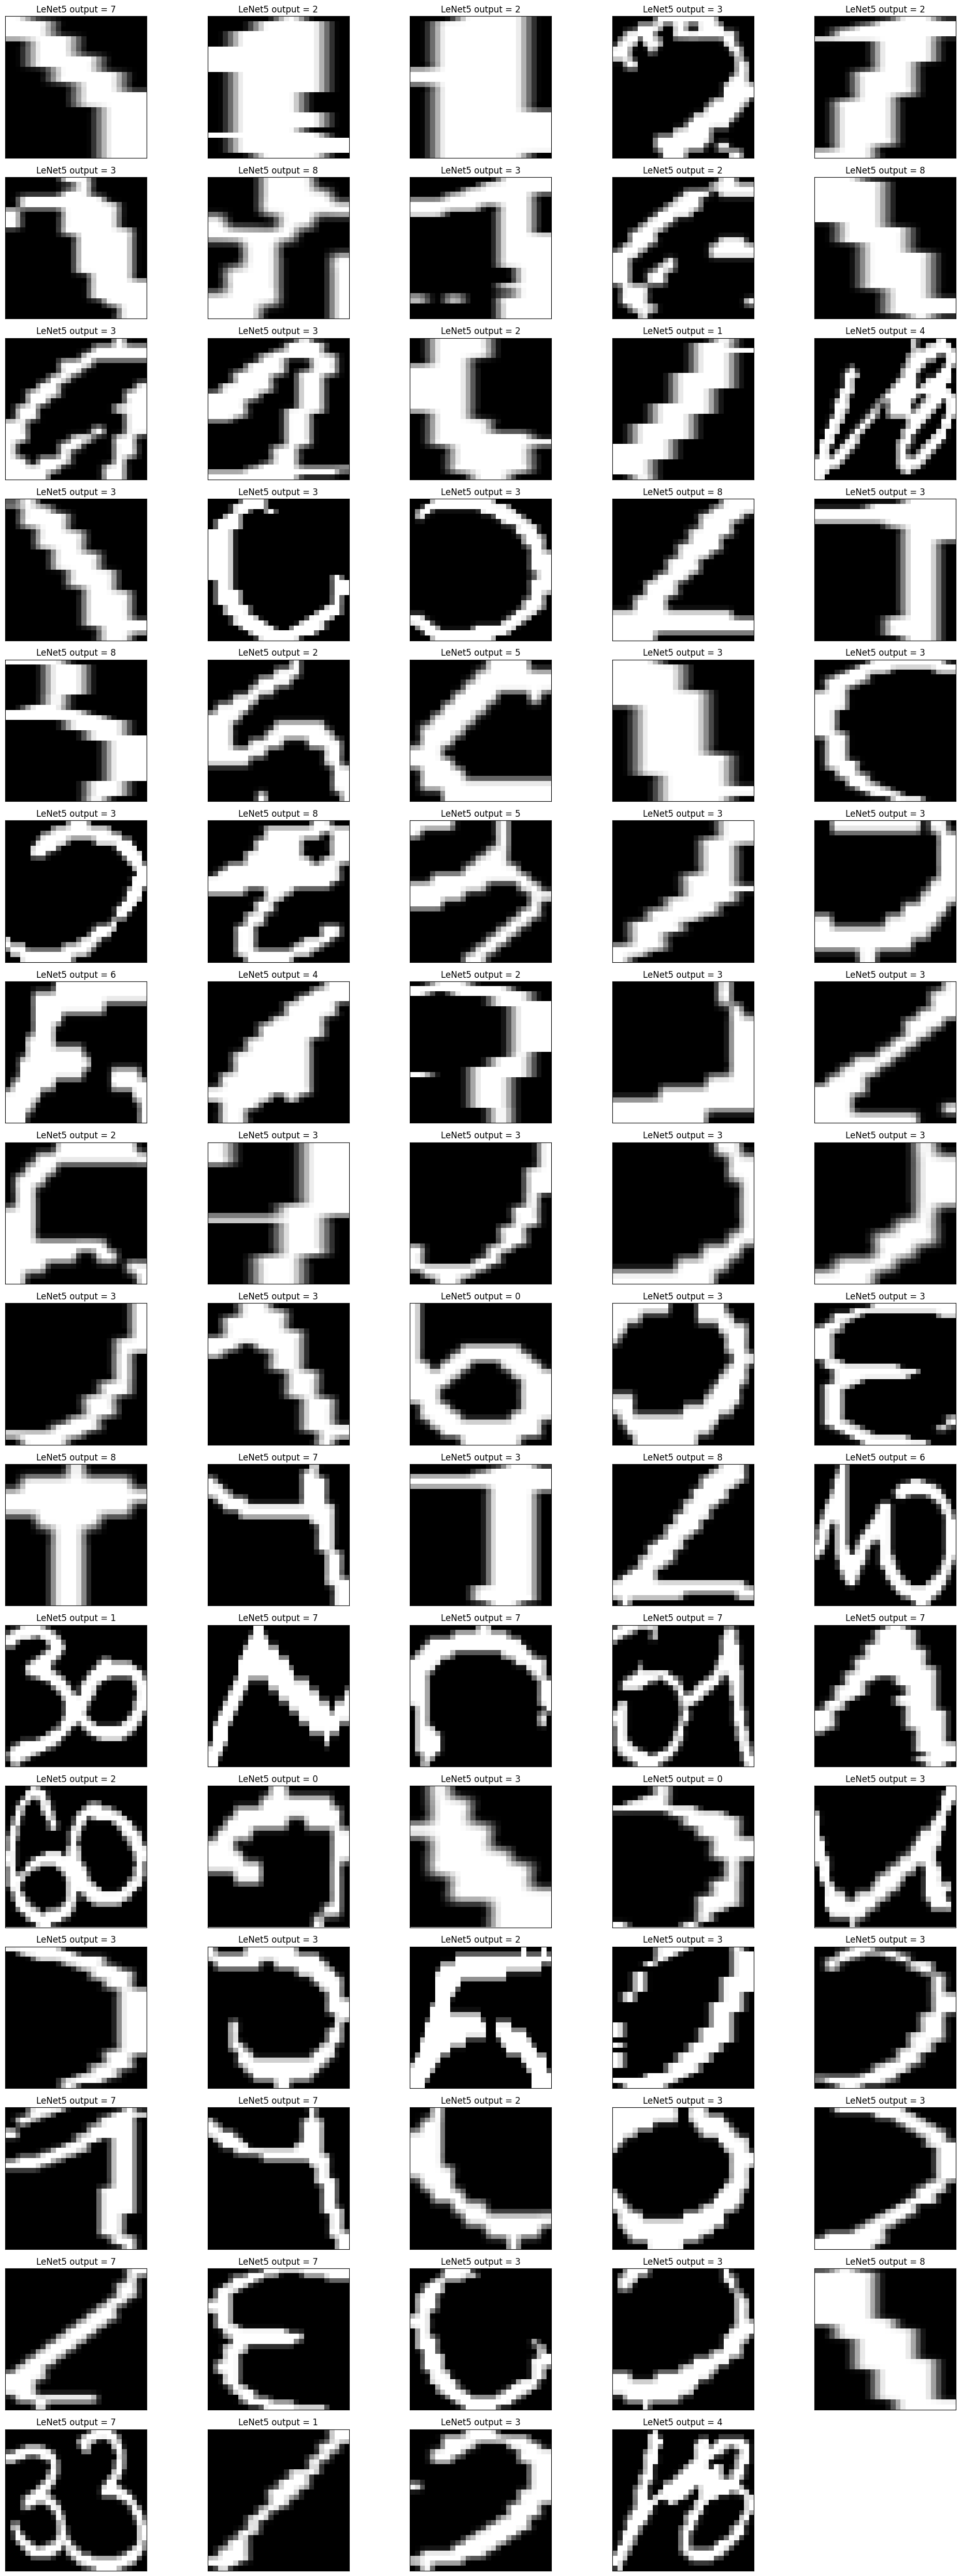

In [56]:
# Show some random training and test images
images_2_show = [x.to_numpy().reshape(28, 28) for i, x in img_x.iterrows()];
titles_2_show = ['LeNet5 output = '+ str(y) for i,y in enumerate(Y_x_pred)]

show_images(images_2_show, titles_2_show, figsize=(20,50))